# Single Envelope Model

The goal is to use a single wideband envelope for the simulation as described in [1].

## Example 1: Second harmonic generation

Let's demostrate the code by replicating the first example from [1], quoting:

"We solved Eq. (11) by a split-step Fourier method exploiting the fourth-order Runge-Kutta scheme for the nonlinear step.
In order to show the validity of our equation, we simulated the propagation of a femtosecond pulse in a $L = 5$ mm long periodically poled lithium tantalate sample (PPLT). To model the refractive index dispersion we employed a Sellmeier model fitted from experimental data [13] and a nonlinear coefficient of $d_{33} = \chi^{(2)}_{LT}/2 = 10.6$ pm/V. In the numerical code wei nserted the exact dispersion relation $k(ω)$. We assumed a first-order quasi-phase-matching (QPM) grating, with a period $\Lambda = 17.4$ μm. We thus allowed a periodic variation of the nonlinear coefficient $\chi^{(2)} = \chi^{(2)}(z) = 2/\pi \chi^{(2)}_{LT} e^{i2π/\Lambda z} + c.c.$ We injected a $T = 60$ fs FWHM long Gaussian pulse, centered around 1400 nm, with I = 10 GW/cm2 peak intensity. The corresponding residual phase mismatch is $k = 2k(\omega_{in}) − k(2\omega_{in}) = 10 000$ m$^{−1}$, where $\omega_{in}$ is the carrier frequency of the input pulse. In the simulation we set the reference frequency $\omega_0$ to be equal to the second harmonic of the input pulse: in this way the second harmonic is stationary in the reference frame $(z,τ)$."

The following are images from Example 1 in [1]. These are the results we'd like to replicate.

![alt text](files\NEE_example1_SHG.png "Title")

## Results

I'm just going to give you the punchline in case you are in a hurry. Below is a video showing the propagation of the pulse as it travels down the crystal. The velocity of the reference frame coincides with the group velocity of the second harmonic, so it looks like the fundamental input pulse is moving to the left (faster than the reference frame), while the generated second harmonic trail looks static. This example nicely illustrates the effect of group velocity mismatch for second harmonic generation.

<div style="text-align: center">
    <video width="80%" controls src="files\SHG.mp4" />
</div>

## The code

We begin by importing the modules needed, including my own. I also run some formatting scripts. You can safely ignore all this.

In [1]:
import numpy as np
from numpy.fft import fft, ifft, fftshift, fftfreq
import matplotlib.pyplot as plt
import time
from scipy import fftpack as sp
from scipy import signal
import copy
from matplotlib import cm
import colorcet as cc
from matplotlib.colors import Normalize

#This are my libraries
import nlo 
import materials
import waveguides
from util import sech

In [2]:
#Formatting stuff
from IPython.core.display import HTML
def css_styling():
    styles = open("custom.css", "r").read()
    return HTML(styles)
css_styling()

In [3]:
plt.rcParams.update({'font.size': 18})

## Units
We'll work in SI base units for the most part. Here we load some constants and also create some variables for scaling units conveniently.

In [4]:
from scipy.constants import pi, c, epsilon_0
nm = 1e-9
um = 1e-6
mm = 1e-3
ps = 1e-12
fs = 1e-15
GHz = 1e9
THz = 1e12

## Time and Frequency domain windows

### General Comments
We need to determine the FFT size $N$, as well the size of the time window $T$ and the total frequency bandwidth $F_\mathrm{BW}$. Both domain will have $N$ points, and these three parameters are related by the uncertainty relations:

$${\Delta t} {\Delta f } = \frac{1}{N}, \\
T F_{\mathrm{BW}} = N.$$

We should make sure that the time and frequency windows are large enough that all important dynamics occur inside them. Obviously, we can order enlarge both at the same time by increasing $N$, and this is computationally costly.

The size of the time window $T$ depends on the group velocity of the pulses propagating in it. It needs to be large enough so that no part of the pulses reach the edge of the domain at any point. Since we will pick the velocity of the moving reference frame, how much the pulses travel depends on the respective group velocity mismatches of all the frequency components with respect to the frame reference velocity. We can get his information from the group velocity mismatch across the frequency bandwidth.

Choosing the frequency window is more complicated since in general we don't know what part of the new generated frequencies are relevant. In practice there will be cascading effects as the pulses travel down the nonlinear crystal. It may be necessary to iteratively narrowdown on what is a good bandwidth for a particular application.

### SHG Example
For this example we'll choose the bandwidth large enough to cover just the fundamental and second harmonics. We can then play with the number of points $N$ until we get a window size that is at least 3 ps long (since that's about what's shown in the paper results). If we didn't know that we could try to guess, run the simulation, check how much the pulse travels, adjust, and so on.

In [5]:
wl_ff = 1400*nm #Fundamental wavelength
f0_ff = c/wl_ff
f0_sh = 2*f0_ff #SHG frequency
wl_sh = c/f0_sh

#In this example we only care about fundamental and second harmonic,
#so, let's set the bandwidth accordingly
BW = 1.2*f0_sh - 0.8*f0_ff

#Now we can create the time and frequency arrays
NFFT = 2**10
Tmax = NFFT/BW
dt = 1/BW
t_start = -2.5*ps
t_stop = t_start + NFFT*dt
t = np.arange(t_start, t_stop, step=dt)
f = fftfreq(NFFT, dt)
Omega = 2*pi*f
df = f[1]-f[0]

We also need to choose a reference frequency $f_{ref}$. Our simulation is a bandpass simulation centered around this reference frequency. So, the natural frequency variable for our simulation is $$\Omega = \omega - \omega_{ref}.$$
I'll try to be consistent and use lower case variable names for absolute frequencies representing $\omega$'s, and variable names starting with an uppper case to represent $\Omega$. For, instance, the variable ```Omega``` that we just created represents $\Omega$, while in the next cell we'll define ```omega_ref``` and ```omega_abs``` which represents $\omega_{ref}$ and $\omega$.

In the next cell we define $f_{ref}$ as the mean frequency between the fundamental and second harmonic. We also define arrays with absolute frequencies, and find the min and max frequencies and wavelengths of our simulation. We may be interested later in knowing things at exactly the fundamental and second harmonics, so having get their indexes is useful. Finally we print everything out for verification.

In [6]:
#Reference frequency
f_ref = (f0_ff + f0_sh)/2
wl_ref = c/f_ref
omega_ref = 2*pi*f_ref

#Absolute frequencies and wavelengths
f_abs = f + f_ref
wl_abs = c/f_abs
omega_abs = 2*pi*f_abs
f_min = np.amin(f_abs)
f_max = np.amax(f_abs)
wl_max = c/f_min
wl_min = c/f_max

#get the frequency indexes for fundamental and second harmonics
f0_ff_index = np.abs(f + f_ref - f0_ff).argmin()
f0_sh_index = np.abs(f + f_ref - f0_sh).argmin()

print('Fundamental wavelength = %0.1f nm' %(wl_ff/nm))
print('SH wavelength = %0.1f nm' %(wl_sh/nm))
print('Fundamental frequency = %0.1f THz' %(f0_ff/THz))
print('SH frequency = %0.1f THz' %(f0_sh*1e-12))
print('Simulation bandwidth = %0.1f THz' %(BW/THz))
print('Time window size = %0.3f ps' %(Tmax/ps))
print('Sampling Rate = %0.3f fs' %(dt/fs))
print('Frequency Resolution = %0.3f GHz' %(df/GHz))
print('Reference wavelength = %0.1f nm' %(wl_ref/nm))
print('Reference frequency = %0.1f THz' %(f_ref/THz))
print('Minimum absolute frequency = %0.1f THz' %(f_min/THz))
print('Maximum absolute frequency = %0.1f THz' %(f_max/THz))
print('Minimum absolute wavelength = %0.1f nm' %(c/f_max/nm))
print('Maximum absolute wavelength = %0.1f um' %(c/f_min/nm))
print('Array index for fundamental = %i' %(f0_ff_index))
print('Array index for SH = %i' %(f0_sh_index))

Fundamental wavelength = 1400.0 nm
SH wavelength = 700.0 nm
Fundamental frequency = 214.1 THz
SH frequency = 428.3 THz
Simulation bandwidth = 342.6 THz
Time window size = 2.989 ps
Sampling Rate = 2.919 fs
Frequency Resolution = 334.590 GHz
Reference wavelength = 933.3 nm
Reference frequency = 321.2 THz
Minimum absolute frequency = 149.9 THz
Maximum absolute frequency = 492.2 THz
Minimum absolute wavelength = 609.1 nm
Maximum absolute wavelength = 2000.0 um
Array index for fundamental = 704
Array index for SH = 320


## Material properties

I'm going to load the refractive index of lithium tantalate from my personal library named <font color=magenta> materials</font>. In that library I implement mostly Sellmeier's equations obtained from https://refractiveindex.info/ for a few common materials.

Refractive index at fundamental = 2.121
Refractive index at second harmonic = 2.163 


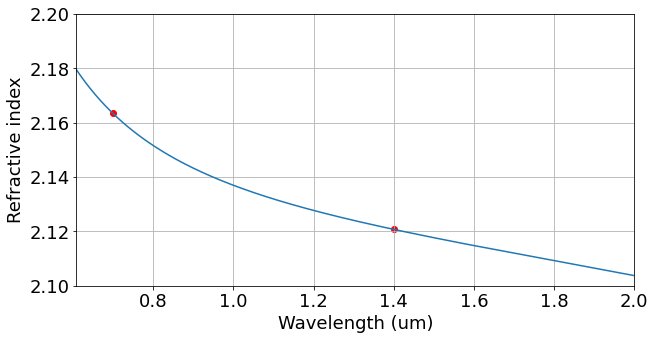

In [7]:
nLN = materials.refractive_index('LT_MgO_e', wl_abs/um)
nw = nLN[f0_ff_index]
n2w = nLN[f0_sh_index]

plt.rcParams['figure.figsize'] = [10, 5]
fig = plt.figure()
ax1 = fig.add_subplot(111)

ax1.plot(fftshift(wl_abs/um), fftshift(nLN))
ax1.scatter(wl_abs[f0_ff_index]/um, nw, c='r')
ax1.scatter(wl_abs[f0_sh_index]/um, n2w, c='r')
ax1.set_xlim([wl_min/um, wl_max/um])
ax1.set_ylim([2.1,2.2])
ax1.set_xlabel('Wavelength (um)')
ax1.set_ylabel('Refractive index')
ax1.grid(True)

print('Refractive index at fundamental = %0.3f' %(nw))
print('Refractive index at second harmonic = %0.3f ' %(n2w))

Now we'll get the propagation constant as usual:
$$ \beta = \frac{\omega n}{c} ,$$

as well as the group velocity and GVD:
$$ 
v_g = \frac{1}{\beta_1} = \left( \frac{\partial \beta}{\partial \omega} \right)^{-1} \\
\mathrm{GVD} = \beta_2 = \frac{\partial^2 \beta}{\partial \omega^2} .
$$

We also need to get the higher order dispersion operator; this can be obtained from the propagation constant as follows:
$$D = \beta(\Omega) - \beta_0 \big|_{\Omega=0} - \frac{\Omega}{v_{ref}}.$$

For this example we'll use $v_{ref} = v_g(2 \omega_0)$.

At this point we can also compute the GVM ($\Delta \beta^\prime $) between the fundamental signal and the moving reference frame:
$$ \Delta \beta^\prime = \frac{1}{v_{ref}} - \frac{1}{v_g(\omega_0)}, $$
and then we can compute how much a pulse at $\omega_0$ will travel in a crystal of length $L$,
$$ \tau =  L \Delta \beta^\prime. $$

GVD at 0.933 um = 243.207 fs^2/mm
GVD at 1.400 um = 116.691 fs^2/mm
Group velocity mismatch between 1.40 um wave and reference frame = 0.327 ps/mm


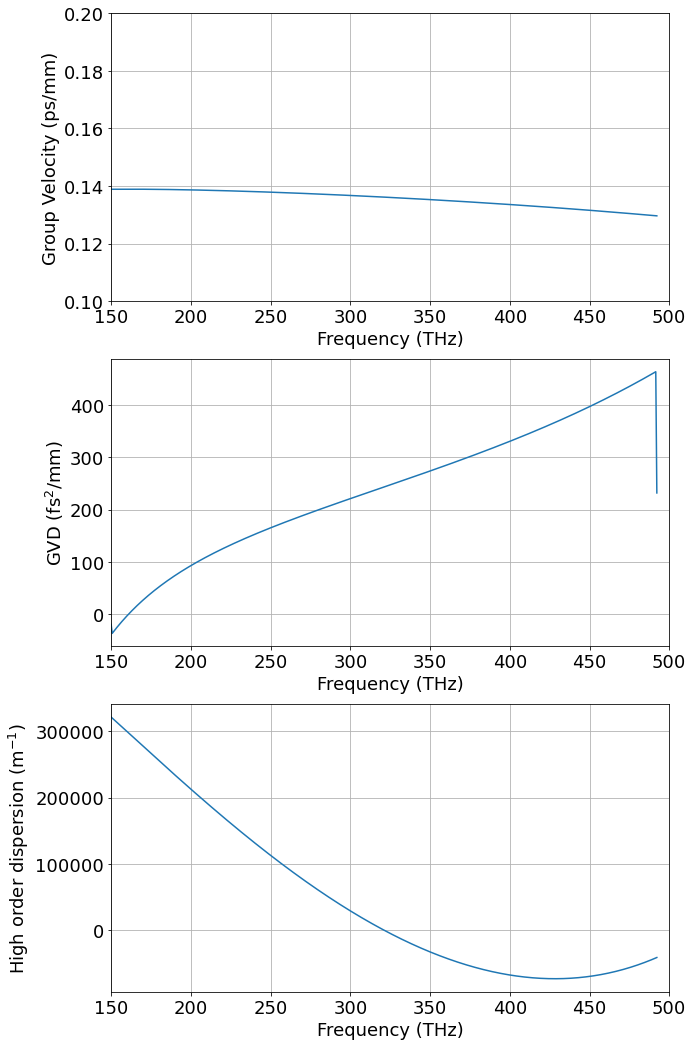

In [8]:
beta = omega_abs*nLN/c
beta_1 = fftshift(np.gradient(fftshift(beta), 2*pi*df))
beta_2 = fftshift(np.gradient(fftshift(beta_1), 2*pi*df))
vg = 1/beta_1

beta_ref = beta[0]
v_ref = vg[f0_sh_index]
D = beta - beta_ref - Omega/v_ref

plt.rcParams['figure.figsize'] = [10, 18]
fig = plt.figure()
ax1 = fig.add_subplot(311)
ax2 = fig.add_subplot(312)
ax3 = fig.add_subplot(313)
ax1.plot(fftshift(f_abs)/THz, fftshift(vg)/(mm/ps));
ax2.plot(fftshift(f_abs)/THz, fftshift(beta_2)/(fs**2/mm));
ax1.set_ylabel('Group Velocity (ps/mm)'); ax2.set_ylabel('GVD (fs$^2$/mm)')
ax1.set_xlabel('Frequency (THz)'); ax2.set_xlabel('Frequency (THz)');
ax1.set_xlim(150, 500); ax2.set_xlim(150, 500)
ax1.set_ylim(0.1,0.2)
ax1.grid(True); ax2.grid(True)
ax3.plot(fftshift(f_abs)/THz, fftshift(D));
ax3.set_xlabel('Frequency (THz)');
ax3.set_ylabel('High order dispersion (m$^{-1}$)');
ax3.grid(True)
ax3.set_xlim(150, 500);

#Some extra information
GVM = 1/v_ref - 1/vg[f0_ff_index]

print('GVD at %0.3f um = %0.3f fs^2/mm' %(wl_ref*1e6, beta_2[0]*1e27))
print('GVD at %0.3f um = %0.3f fs^2/mm' %(wl_ff*1e6, beta_2[f0_ff_index]*1e27))
print('Group velocity mismatch between %0.2f um wave and reference frame = %0.3f ps/mm' %(wl_ff*1e6, GVM/(ps/mm)))

## Quasi Phase Matching

We can get the ideal poling period for SHG is:
$$
\Lambda = \frac{\lambda_{2\omega}}{n_{2\omega} - n_\omega}
$$

In [9]:
poling_period = (wl_sh)/(n2w-nw)
print('Optimal Poling period for SHG starting from pump at %0.2f um is %0.2f um' %(wl_ff*1e6, poling_period*1e6))

delta_b = 2*beta[f0_ff_index] - beta[f0_sh_index]
print('Phase mismatch before poling = %0.1f 1/m' %(delta_b))
print('Phase mismatch after poling = %0.2f 1/m' %(delta_b+2*pi/poling_period))

Optimal Poling period for SHG starting from pump at 1.40 um is 16.40 um
Phase mismatch before poling = -383043.9 1/m
Phase mismatch after poling = 0.00 1/m


And now we can modulate the nonlinearity as function of distance using this period. What I want is a function that returns $\chi^{(2)}$ vs distance for any poling pattern. I call this function ```chi2```.

In [10]:
def chi2(z, deff, pp):
    poling = (2/pi)*np.cos(z*2*pi/pp)
    return 2*deff*poling

## Input pulse creation

We can find the peak value of the pulse from the intensity
$$
E_p = \sqrt{\frac{2 I}{n_\omega c \epsilon_0}}.
$$

The reference frequency $\omega_{ref}$ is mapped to zero in $\Omega$. So, to generate a pulse at frequency $\omega_0$ we need to modulate it:
$$
p(t) e^{j (\omega_0 - \omega_{ref}) t} = p(t) e^{j \Omega_0 t}.
$$

Let's now generate the pulse, add a bit of noise to it, and plot it to verify it is at the right frequency and looks like we expect it to look.

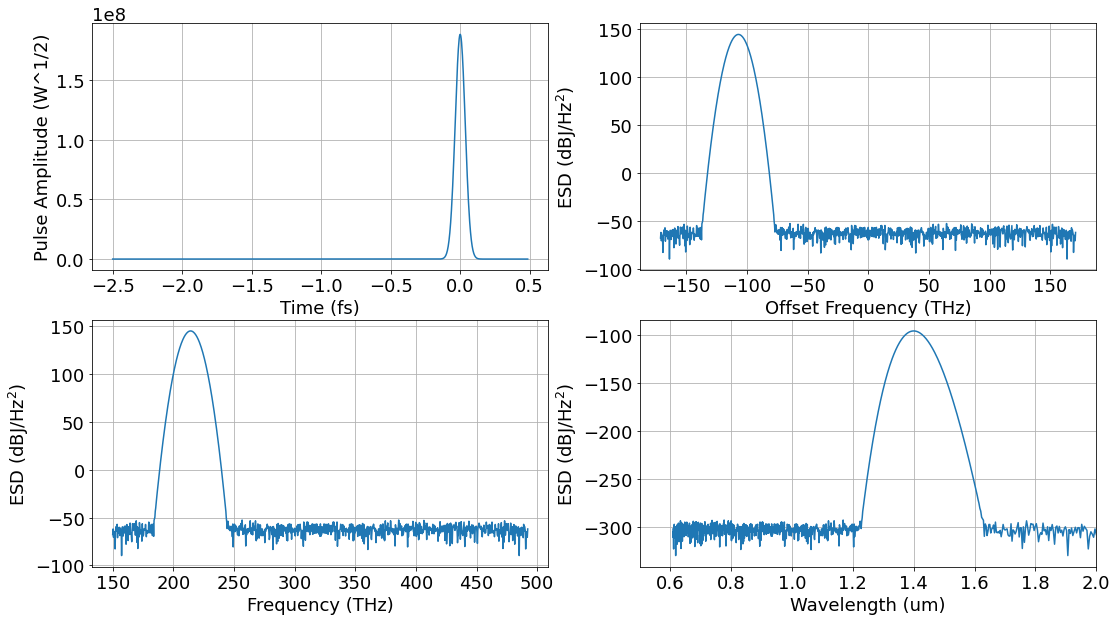

In [14]:
#Frequency offset from reference:
Omega_0 = 2*pi*(f0_ff - f_ref)

#Peak value:
Intensity = 10e13 #10GW/cm^2
n = nw
Epeak = np.sqrt(2*Intensity/(n*c*epsilon_0))

#Pulse width:
tau = 60e-15 

#Noise floor
noise = 0.01*np.random.normal(size=NFFT)

#Pulse creation
pulse = Epeak*np.exp(-2*np.log(2)*(t/tau)**2)*np.exp(1j*Omega_0*t)
pulse = pulse + noise

plt.rcParams['figure.figsize'] = [18, 10]
fig = plt.figure()
ax1 = fig.add_subplot(221)
ax2 = fig.add_subplot(222)
ax3 = fig.add_subplot(223)
ax4 = fig.add_subplot(224)

nlo.plot_mag(t*1e12, pulse, ax=ax1)
nlo.plot_ESD_dB(t*1e12, pulse, ax=ax2, label='ESD (dBJ/Hz$^2$)')
nlo.plot_ESD_dB_absfreq(t*1e12, pulse, f_ref*1e-12, ax=ax3, label='ESD (dBJ/Hz$^2$)')
nlo.plot_ESD_dB_vs_wavelength(t, pulse, f_ref, ax=ax4, xlim=[0.5,2], label='ESD (dBJ/Hz$^2$)');

## Nonlinear  Stuff

In [15]:
def chi(z):
    return chi2(z, deff, pp)*omega_ref/(4*nLN[0]*c)

def NEE_v1(z, A):
    Aup = signal.resample(A, Nup*NFFT) #upsampled signal
    tup = np.linspace(t[0], t[-1], Nup*NFFT) #upsampled time
    
    phi = omega_ref*tup - (beta_ref - omega_ref/v_ref)*z
    f1up = Aup*Aup*np.exp(1j*phi) + 2*Aup*np.conj(Aup)*np.exp(-1j*phi)
    
    f1 = signal.resample(f1up, NFFT) #Downsample
    
    f1_deriv = np.gradient(f1, dt)    
    f = -1j*chi(z)*f1  - 1*(chi(z)/omega_ref)*f1_deriv
    return f

In [16]:
def nonlinear_propagation(t, A, L, h, D, chi, method='NEE', Nup=4):
    
    #Calculate number of steps needed
    Nsteps = int(L/h)+1
    
    #Let's inform the user after every 0.5mm (hard-coded)
    zcheck_step = 0.5e-3
    zcheck = zcheck_step
    tic = time.time()
    
    #Initialize the array that will store the full pulse evolution
    A_evol = 1j*np.zeros([t.size, Nsteps+1])
    A_evol[:,0] = A #Initial value
    
    #If chi is a constant then make if a function
    if not callable(chi):
        def chi(z):
            return z
    
    #Load the appropriate function for the method chosen
    if method=='NEE':
        fnl = NEE_v1
    elif method=='NEE_v2':
        pass
    
    #Dispersion operator for step size h
    Dh = np.exp(-1j*D*h)
    
    #Here we go, initialize z tracker and calculate first half dispersion step
    z = 0
    A = ifft(np.exp(-1j*D*h/2)*fft(A)) #Half step
    for kz in range(Nsteps):     

        #Nonlinear step
        #Runge-Kutta 4th order
        k1 = fnl(z    , A       )
        k2 = fnl(z+h/2, A+h*k1/2)
        k3 = fnl(z+h/2, A+h*k2/2)
        k4 = fnl(z+h  , A+h*k3  )
        A = A + (h/6)*(k1+2*k2+2*k3+k4) 
        z = z + h
        
        #Linear full step (two half-steps back to back)
        A = ifft(Dh*fft(A))
        
        #Save evolution
        A_evol[:, kz+1] = A
        
        #Let's inform the user now
        if round(z*1e3,3)==round(zcheck*1e3,3):
            tdelta = time.time() - tic
            print('Completed propagation along %0.1f mm (%0.1f s)' %(z*1e3, tdelta))
            tic = time.time()
            zcheck += zcheck_step

    A = ifft(np.exp(1j*D*h/2)*fft(A)) #Final half dispersion step back
    
    return A, A_evol  

In [17]:
Nup = 4 #Upsampling factor

#Crystal parameters
L = 5e-3
h = 1e-3/100
Nsteps = int(L/h)+1
d33 = 10.6e-12
deff = d33
pp = poling_period

print('Crystal length = %0.2f mm' %(L*1e3))
print('Step size = %0.2f um' %(h*1e6))
print('Number of steps = %i' %(Nsteps))
print('Nonlinear coefficient, d33 = %0.2f pm/V' %(d33*1e12))
print('Using periodic poling with period = %0.3f um' %(pp*1e6))

Crystal length = 5.00 mm
Step size = 10.00 um
Number of steps = 500
Nonlinear coefficient, d33 = 10.60 pm/V
Using periodic poling with period = 16.403 um


## Single pass

In [18]:
# [a, a_evol] = propagate(pulse, D)
[a, a_evol] = nonlinear_propagation(t, pulse, L, h, D, chi=chi)

Completed propagation along 0.5 mm (0.2 s)
Completed propagation along 1.0 mm (0.2 s)
Completed propagation along 1.5 mm (0.2 s)
Completed propagation along 2.0 mm (0.2 s)
Completed propagation along 2.5 mm (0.2 s)
Completed propagation along 3.0 mm (0.2 s)
Completed propagation along 3.5 mm (0.2 s)
Completed propagation along 4.0 mm (0.2 s)
Completed propagation along 4.5 mm (0.2 s)
Completed propagation along 5.0 mm (0.2 s)


Text(0.5, 0, 'Time (ps)')

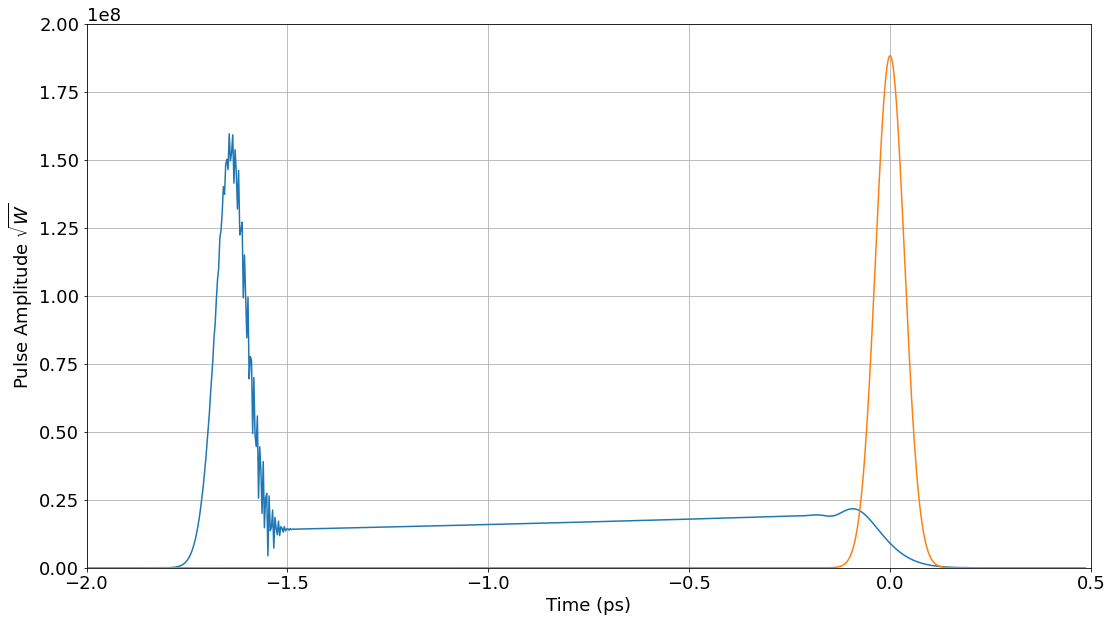

In [19]:
ax1 = nlo.plot_mag(t*1e12, a)
ax1 = nlo.plot_mag(t*1e12, pulse, ax=ax1)
ax1.set_xlim(-2,0.5)
ax1.set_ylim(0,2e8)
ax1.set_ylabel('Pulse Amplitude $\sqrt{W}$')
ax1.set_xlabel('Time (ps)')

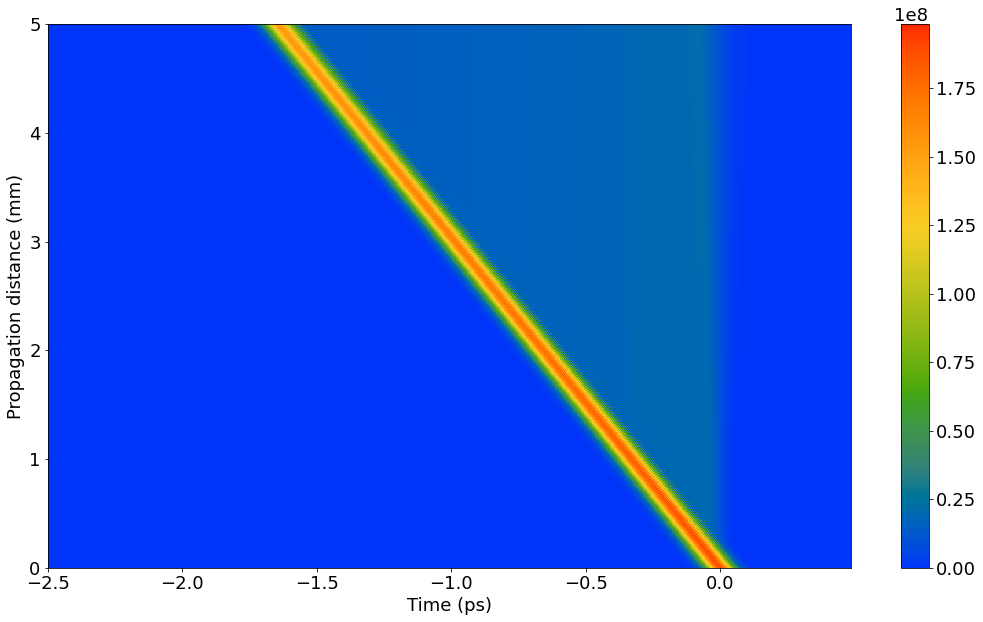

In [20]:
X,Y = np.meshgrid(t*1e12, np.arange(Nsteps+1)*h*1e3)
fig = plt.figure()
ax = fig.add_subplot(111)
im = ax.pcolormesh(X, Y, (np.transpose(np.abs(a_evol))), cmap = cc.cm["rainbow"])
ax.set_xlabel('Time (ps)')
ax.set_ylabel('Propagation distance (mm)')
ax.set_ylim([0,5])
plt.colorbar(im, ax=ax)

## Filter and plot harmonics

(150.0, 500.0)

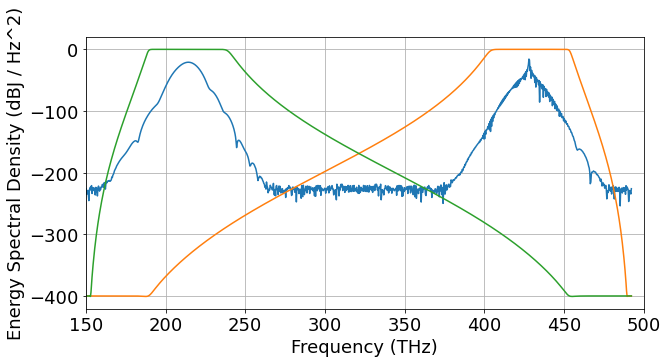

In [21]:
filter_bw = 50e12

f1 = (f0_ff - filter_bw/2 - f_min)/(f_max-f_min)
f2 = (f0_ff + filter_bw/2 - f_min)/(f_max-f_min)
sos = signal.butter(15, [f1, f2], 'bandpass', output='sos')
_, h_ff = signal.sosfreqz(sos, worN=NFFT)

f1 = (f0_sh - filter_bw/2 - f_min)/(f_max-f_min)
f2 = (f0_sh + filter_bw/2 - f_min)/(f_max-f_min)
sos = signal.butter(15, [f1, f2], 'bandpass', output='sos')
_, h_sh = signal.sosfreqz(sos, worN=NFFT)

a_sh = ifft(fft(a)*fftshift(h_sh))
a_ff = ifft(fft(a)*fftshift(h_ff))

plt.rcParams['figure.figsize'] = [10, 5]
ax1 = nlo.plot_ESD_dB_absfreq(t*1e12, a/np.amax(np.abs(a)), f_ref*1e-12)
ax1.plot(fftshift(f+f_ref)*1e-12, 20*np.log10(abs(h_sh + 1e-20)));
ax1.plot(fftshift(f+f_ref)*1e-12, 20*np.log10(abs(h_ff + 1e-20)))
# ax1.set_ylim([-100,10])
ax1.set_xlim([150, 500])

(0.0, 200000000.0)

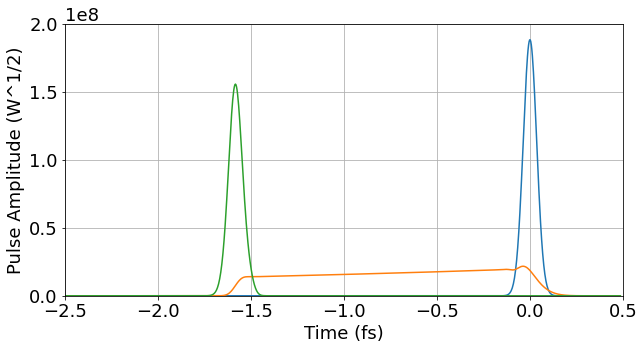

In [22]:
plt.rcParams['figure.figsize'] = [10, 5]
ax1 = nlo.plot_mag(t*1e12, pulse)
ax1 = nlo.plot_mag(t*1e12, a_sh, ax=ax1)
ax1 = nlo.plot_mag(t*1e12, a_ff, ax=ax1)
ax1.set_xlim(-2.5,0.5)
ax1.set_ylim(0, 2e8)

## Spectrum

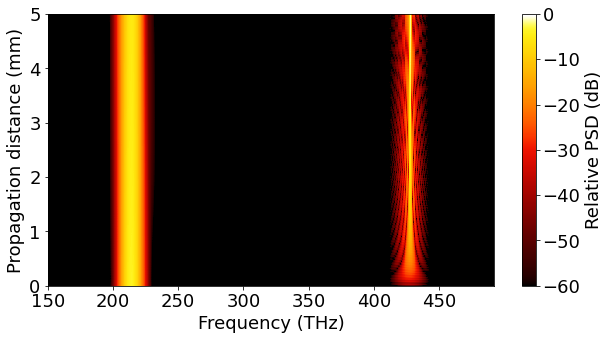

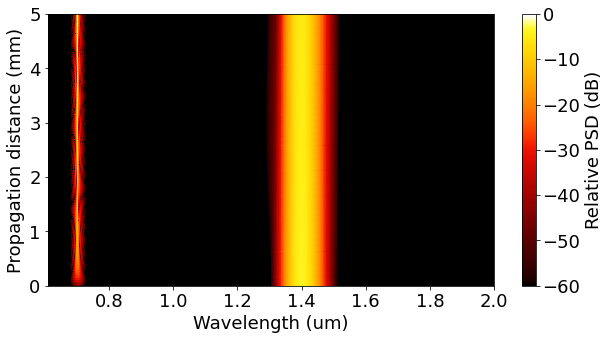

In [23]:
A_evol = np.zeros((t.size, Nsteps+1))

for k in range(Nsteps+1):
    x = a_evol[:,k]
    _ , Aesd = nlo.get_esd(t*1e15, x)
    A_evol[:,k] = 10*np.log10(Aesd)

A_evol = A_evol - np.amax(A_evol)
A_evol = fftshift(A_evol, axes=0)

X,Y = np.meshgrid(fftshift(f+f_ref)*1e-12, np.arange(Nsteps+1)*h*1e3)
plt.figure()
plt.pcolormesh(X, Y, (np.transpose(A_evol)), cmap = cc.cm["fire"], vmin=-60, vmax=0)
cb = plt.colorbar()
cb.set_label('Relative PSD (dB)')
plt.xlabel('Frequency (THz)')
plt.ylabel('Propagation distance (mm)');

wl_array = c/(fftshift(f)+f_ref)*1e6
Xwl,Ywl = np.meshgrid(wl_array, np.arange(Nsteps+1)*h*1e3)
plt.figure()
plt.pcolormesh(Xwl, Ywl, (np.transpose(A_evol)), cmap = cc.cm["fire"], vmin=-60, vmax=0)
cb = plt.colorbar()
cb.set_label('Relative PSD (dB)')
plt.xlabel('Wavelength (um)')
plt.ylabel('Propagation distance (mm)');

## References
[1] M. Conforti, F. Baronio, and C. De Angelis, “Nonlinear envelope equation for broadband optical pulses in quadratic media,” Phys. Rev. A, vol. 81, no. 5, p. 053841, May 2010, doi: 10.1103/PhysRevA.81.053841.

In [24]:
%load_ext version_information
%version_information scipy, numpy, matplotlib

Software versions
Python 3.7.6 64bit [MSC v.1916 64 bit (AMD64)]
IPython 7.13.0
OS Windows 10 10.0.16299 SP0
scipy 1.4.1
numpy 1.18.1
matplotlib 3.2.1
Fri Apr 10 13:54:41 2020 Pacific Daylight Time